# BlackKnight Data Challenge - Document Classification

This project is designed for document classification based on a labeled dataset with encoded text content. This notebook is for data exploration and model training only. For prediction application and model deployment, check out [my Github repo](https://github.com/yutongwDS/DocumentClassification) for more info.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import os
np.random.seed(0)

## Data Preprocessing

### Explore and Clean Dataset

The raw dataset is in csv format, with 62203 documents as rows, and two columns for document label and content separately. All words in document content is encoded. Dataset contains 14 unique labels, among which BILL is the most frequent one with 18968 documents, while APPLICATION and INTENT TO CANCEL NOTICE are the least with 229 documents. Several documents have empty content, and thus removed from the dataset for training or validation. Considering is nearly 100 times more than APPLICATION, the dataset could be evaluated as severely imbalanced.

In [ ]:
raw = pd.read_csv("../bkfs/shuffled-full-set-hashed.csv", header=None)
raw.columns = ["Label", "Content"]
raw.head()

In [ ]:
raw.shape

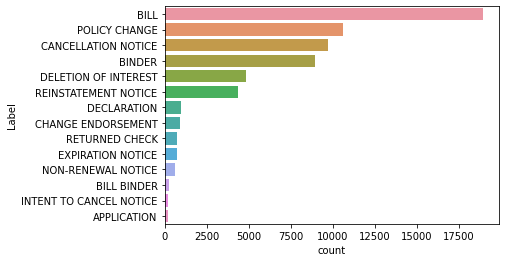

In [5]:
ax = sns.countplot(y="Label", data=raw, order=raw['Label'].value_counts().index)

In [6]:
raw["Label"].value_counts()

BILL                       18968
POLICY CHANGE              10627
CANCELLATION NOTICE         9731
BINDER                      8973
DELETION OF INTEREST        4826
REINSTATEMENT NOTICE        4368
DECLARATION                  968
CHANGE ENDORSEMENT           889
RETURNED CHECK               749
EXPIRATION NOTICE            734
NON-RENEWAL NOTICE           624
BILL BINDER                  289
INTENT TO CANCEL NOTICE      229
APPLICATION                  229
Name: Label, dtype: int64

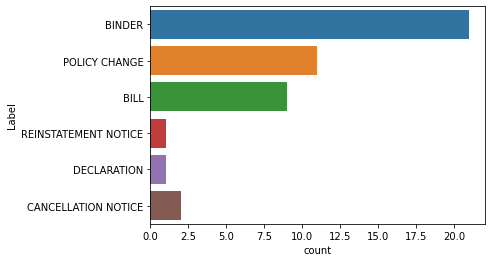

In [7]:
ax = sns.countplot(y="Label", data=raw[raw.isna().any(axis=1)])

In [8]:
df = raw.dropna() # remove empty documents

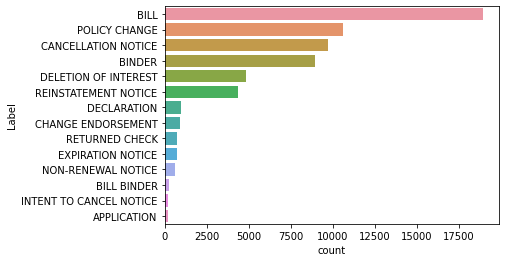

In [9]:
ax = sns.countplot(y="Label", data=df, order=df["Label"].value_counts().index)

### Splitting Training and Test Set

Use 80% as training set and 20% as validation set for model evaluation and selection

In [10]:
X, y = df["Content"], df["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### TF-IDF Transform

In [11]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X_train)

TfidfVectorizer()

In [12]:
pickle.dump(vectorizer, open('TFIDF_Vectorizer.pkl', 'wb'))

In [13]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

Below is what the first five documents look like after TF-IDF transformation. Each column is a word and each value in matrix is a tf-idf calculated frequency.

In [13]:
X_vec = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
X_vec.head()

000010500bb2  000011010f32  00001f56b526  00002001d9db  00002b9f620c  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   000043294cf0  0000441c5e12  00004fd8d7f2  0000532d7b46  000053bc1c64  ...  \
0           0.0           0.0           0.0           0.0           0.0  ...   
1           0.0           0.0           0.0           0.0           0.0  ...   
2           0.0           0.0           0.0           0.0           0.0  ...   
3           0.0           0.0           0.0           0.0           0.0  ...   
4           0.0           0.0           0.0           0.0           0.0  ...   

   ffff8e63af75  ffff9d5a49c2  ffffafc3fe23  ffffb215b2d1  ffffcada1151  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   ffffd75cb998  ffffdf648133  ffffe20a37ba  ffffeb221d43  fffff479abe0  
0           0.0           0.0           0.0           0.0           0.0  
1           0.0           0.0           0.0           0.0           0.0  
2           0.0           0.0           0.0           0.0           0.0  
3           0.0           0.0           0.0           0.0           0.0  
4           0.0           0.0           0.0           0.0           0.0  

[5 rows x 1037934 columns]

## Model Training

Since the dataset size is too large for local machine, we tested two most popular classfication methods: Random Forest and XGBoost. They both scored 85% accuracy on validation set. Considering the trained Random Forest model is much larger than XGBoost, which causes more memory requirements on deployment, we selected XGBoost as final model. 

### Random Forest

In [21]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [23]:
y_pred_rf = rf.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred_rf))

                         precision    recall  f1-score   support

            APPLICATION       0.88      0.48      0.62        46
                   BILL       0.89      0.90      0.90      3792
            BILL BINDER       0.50      0.17      0.26        58
                 BINDER       0.82      0.88      0.85      1790
    CANCELLATION NOTICE       0.81      0.85      0.83      1946
     CHANGE ENDORSEMENT       0.85      0.72      0.78       178
            DECLARATION       0.31      0.08      0.13       193
   DELETION OF INTEREST       0.93      0.87      0.90       965
      EXPIRATION NOTICE       0.90      0.66      0.76       147
INTENT TO CANCEL NOTICE       0.79      0.41      0.54        46
     NON-RENEWAL NOTICE       0.94      0.59      0.73       125
          POLICY CHANGE       0.79      0.87      0.83      2123
   REINSTATEMENT NOTICE       0.95      0.88      0.92       873
         RETURNED CHECK       0.97      0.78      0.87       150

               accuracy

In [44]:
pd.crosstab(y_test, y_pred_rf, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted                APPLICATION  BILL  BILL BINDER  BINDER  \
True                                                              
APPLICATION                       22     6            0      16   
BILL                               1  3419            9      74   
BILL BINDER                        0    26           10      12   
BINDER                             1    55            0    1572   
CANCELLATION NOTICE                0   143            0      11   
CHANGE ENDORSEMENT                 0     3            0       5   
DECLARATION                        1    30            0     101   
DELETION OF INTEREST               0     1            0       2   
EXPIRATION NOTICE                  0    32            0       2   
INTENT TO CANCEL NOTICE            0     7            0       1   
NON-RENEWAL NOTICE                 0     1            0       0   
POLICY CHANGE                      0    86            1     112   
REINSTATEMENT NOTICE               0    14            0       8   
RETURNED CHECK                     0    14            0       3   
All                               25  3837           20    1919   

Predicted                CANCELLATION NOTICE  CHANGE ENDORSEMENT  DECLARATION  \
True                                                                            
APPLICATION                                0                   0            0   
BILL                                     127                   1           12   
BILL BINDER                                0                   0            0   
BINDER                                     7                   1            7   
CANCELLATION NOTICE                     1648                   0            3   
CHANGE ENDORSEMENT                         6                 129            2   
DECLARATION                                7                   0           16   
DELETION OF INTEREST                     103                   1            3   
EXPIRATION NOTICE                          6                   0            2   
INTENT TO CANCEL NOTICE                   17                   0            0   
NON-RENEWAL NOTICE                        42                   0            0   
POLICY CHANGE                             31                  19            7   
REINSTATEMENT NOTICE                      41                   0            0   
RETURNED CHECK                             1                   0            0   
All                                     2036                 151           52   

Predicted                DELETION OF INTEREST  EXPIRATION NOTICE  \
True                                                               
APPLICATION                                 0                  0   
BILL                                        0                  5   
BILL BINDER                                 0                  0   
BINDER                                      1                  0   
CANCELLATION NOTICE                        45                  1   
CHANGE ENDORSEMENT                          1                  0   
DECLARATION                                 9                  1   
DELETION OF INTEREST                      844                  0   
EXPIRATION NOTICE                           1                 97   
INTENT TO CANCEL NOTICE                     1                  0   
NON-RENEWAL NOTICE                          1                  0   
POLICY CHANGE                               7                  3   
REINSTATEMENT NOTICE                        2                  1   
RETURNED CHECK                              0                  0   
All                                       912                108   

Predicted                INTENT TO CANCEL NOTICE  NON-RENEWAL NOTICE  \
True                                                                   
APPLICATION                                    0                   0   
BILL                                           0                   0   
BILL BINDER                          

In [27]:
pickle.dump(rf, open('RandomForest.pkl', 'wb'))

### XGBoost

### Hyperparameter Tuning

In [16]:
from sklearn.model_selection import RandomizedSearchCV

In [14]:
estimator = GradientBoostingClassifier()

In [26]:
param_grid = {
    'learning_rate': [0.1, 1],
    'n_estimators': [50, 100],
    'max_depth': [3, 9],
    'subsample': [0.5, 1]
}

In [31]:
xgbCV = RandomizedSearchCV(estimator, param_grid, scoring='accuracy', verbose=1, n_jobs=-1) # f1_macro favors performance on minority class
xgbCV.fit(X_train, y_train)
print('Best parameters found by grid search are:', xgbCV.best_params_)

In [32]:
pickle.dump(xgbCV.best_estimator_, open('XGB.pkl', 'wb'))

In [34]:
os.getcwd()

'/Users/yt/PycharmProjects/DocumentClassification'

In [37]:
y_pred_xgb = xgbCV.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

                         precision    recall  f1-score   support

            APPLICATION       0.56      0.54      0.55        46
                   BILL       0.89      0.89      0.89      3792
            BILL BINDER       0.20      0.17      0.18        58
                 BINDER       0.87      0.86      0.86      1790
    CANCELLATION NOTICE       0.85      0.86      0.86      1946
     CHANGE ENDORSEMENT       0.84      0.72      0.77       178
            DECLARATION       0.29      0.24      0.26       193
   DELETION OF INTEREST       0.93      0.92      0.92       965
      EXPIRATION NOTICE       0.77      0.71      0.74       147
INTENT TO CANCEL NOTICE       0.68      0.61      0.64        46
     NON-RENEWAL NOTICE       0.82      0.78      0.80       125
          POLICY CHANGE       0.79      0.83      0.81      2123
   REINSTATEMENT NOTICE       0.94      0.92      0.93       873
         RETURNED CHECK       0.91      0.85      0.88       150

               accuracy

In [38]:
pd.crosstab(y_test, y_pred_xgb, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted                APPLICATION  BILL  BILL BINDER  BINDER  \
True                                                              
APPLICATION                       25     7            0       7   
BILL                               4  3386           23      47   
BILL BINDER                        0    33           10       4   
BINDER                             8    51            4    1533   
CANCELLATION NOTICE                0   118            1       6   
CHANGE ENDORSEMENT                 0     1            1       3   
DECLARATION                        1    31            1      56   
DELETION OF INTEREST               0     2            0       0   
EXPIRATION NOTICE                  0    26            0       1   
INTENT TO CANCEL NOTICE            0     6            0       1   
NON-RENEWAL NOTICE                 0     1            0       0   
POLICY CHANGE                      7   115           11     103   
REINSTATEMENT NOTICE               0    15            0       2   
RETURNED CHECK                     0    10            0       4   
All                               45  3802           51    1767   

Predicted                CANCELLATION NOTICE  CHANGE ENDORSEMENT  DECLARATION  \
True                                                                            
APPLICATION                                0                   1            0   
BILL                                     149                   2           16   
BILL BINDER                                0                   0            0   
BINDER                                     9                   3           22   
CANCELLATION NOTICE                     1675                   2           11   
CHANGE ENDORSEMENT                         2                 128            7   
DECLARATION                                6                   1           47   
DELETION OF INTEREST                      62                   1            3   
EXPIRATION NOTICE                          0                   0            2   
INTENT TO CANCEL NOTICE                    8                   0            0   
NON-RENEWAL NOTICE                         8                   0            0   
POLICY CHANGE                             26                  15           52   
REINSTATEMENT NOTICE                      19                   0            3   
RETURNED CHECK                             0                   0            0   
All                                     1964                 153          163   

Predicted                DELETION OF INTEREST  EXPIRATION NOTICE  \
True                                                               
APPLICATION                                 0                  0   
BILL                                        0                 18   
BILL BINDER                                 0                  0   
BINDER                                      3                  1   
CANCELLATION NOTICE                        44                  4   
CHANGE ENDORSEMENT                          0                  1   
DECLARATION                                 8                  0   
DELETION OF INTEREST                      886                  0   
EXPIRATION NOTICE                           2                105   
INTENT TO CANCEL NOTICE                     1                  0   
NON-RENEWAL NOTICE                          1                  0   
POLICY CHANGE                               9                  6   
REINSTATEMENT NOTICE                        1                  2   
RETURNED CHECK                              0                  0   
All                                       955                137   

Predicted                INTENT TO CANCEL NOTICE  NON-RENEWAL NOTICE  \
True                                                                   
APPLICATION                                    0                   0   
BILL                                           0                   2   
BILL BINDER                          